# **F1 RACE PREDICTION MODEL**
Data and AI play a huge role in F1, especially in deciding race strategies ahead of the race. In this notebook I will walk you through my project

## **Overview**

After extracting the data from [Ergast API](http://ergast.com/mrd/) and preprocessing the data, I will be training an initial basic model with 2 hidden layers, which we will then evaluated to further refine the data structures and find any abnormal outliers.

## **Table of contents**
- 1.0 environment
- 2.0 F1 dataset
    - 2.1 Inspect the data
    - 2.2 Feature Correlation
    - 2.3 Feature Importance
    - 2.4 finishing the dataset
- 3.0 Preprocessing the data
    - 3.1 the classification approch
    - 3.2 split the dataset
    - 3.3 Feature scaling
- 4.0 Initial prediction model
    - 4.1 Train and save the model
    - 4.2 Evaluate the model
- 5.0 Random search for tuning hyperparameters
- 6.0 Final prediction model
    - 6.1 Train and save the model
    - 6.2 Evaluate the model

## **1.0 Project environment**
Import the necessary packages:

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.constraints import max_norm


import random
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## **2.0 F1 dataset**
The first step of building the F1 model was to extract the data which we get the raw data from [Ergast API](http://ergast.com/mrd/) then it was preprocessed and filtered to generate a the dataset we're using in this project.

### **2.1 Inspect the data**

In [3]:
data = pd.read_csv('dataset.csv')
data.head()

race_id  driver_id  start_pos  gap_to_pole  cs_driver_results_missing  \
0       18          1          1        0.000                          1   
1       18          2          5        0.075                          1   
2       18          3          7        0.198                          1   
3       18          4         11        0.227                          1   
4       18          5          3        0.060                          1   

   cs_driver_standing  cs_driver_podium_rate  csa_pos_change  csa_finish_pos  \
0                   0                    0.0             0.0             0.0   
1                   0                    0.0             0.0             0.0   
2                   0                    0.0             0.0             0.0   
3                   0                    0.0             0.0             0.0   
4                   0                    0.0             0.0             0.0   

   p3s_driver_results_missing  p3sa_pos_change_same_circuit  \
0                           0                           1.0   
1                           0                           1.5   
2                           0                           5.0   
3                           0                           4.0   
4                           0                           3.0   

   p3sa_finish_pos_same_circuit  cs_const_results_missing  cs_const_standing  \
0                           3.0                         1                  0   
1                           4.0                         1                  0   
2                           7.0                         1                  0   
3                           2.0                         1                  0   
4                          10.0                         1                  0   

   cs_const_podium_rate  circuit_avg_pos_change  finish_pos  
0                   0.0                   -1.24           1  
1                   0.0                    0.67           2  
2                   0.0                   -0.60           3  
3                   0.0                    3.93           4  
4                   0.0                   -0.95           5

### 2.2 Feature Correlation

<Axes: title={'center': 'Feature Correlations'}>

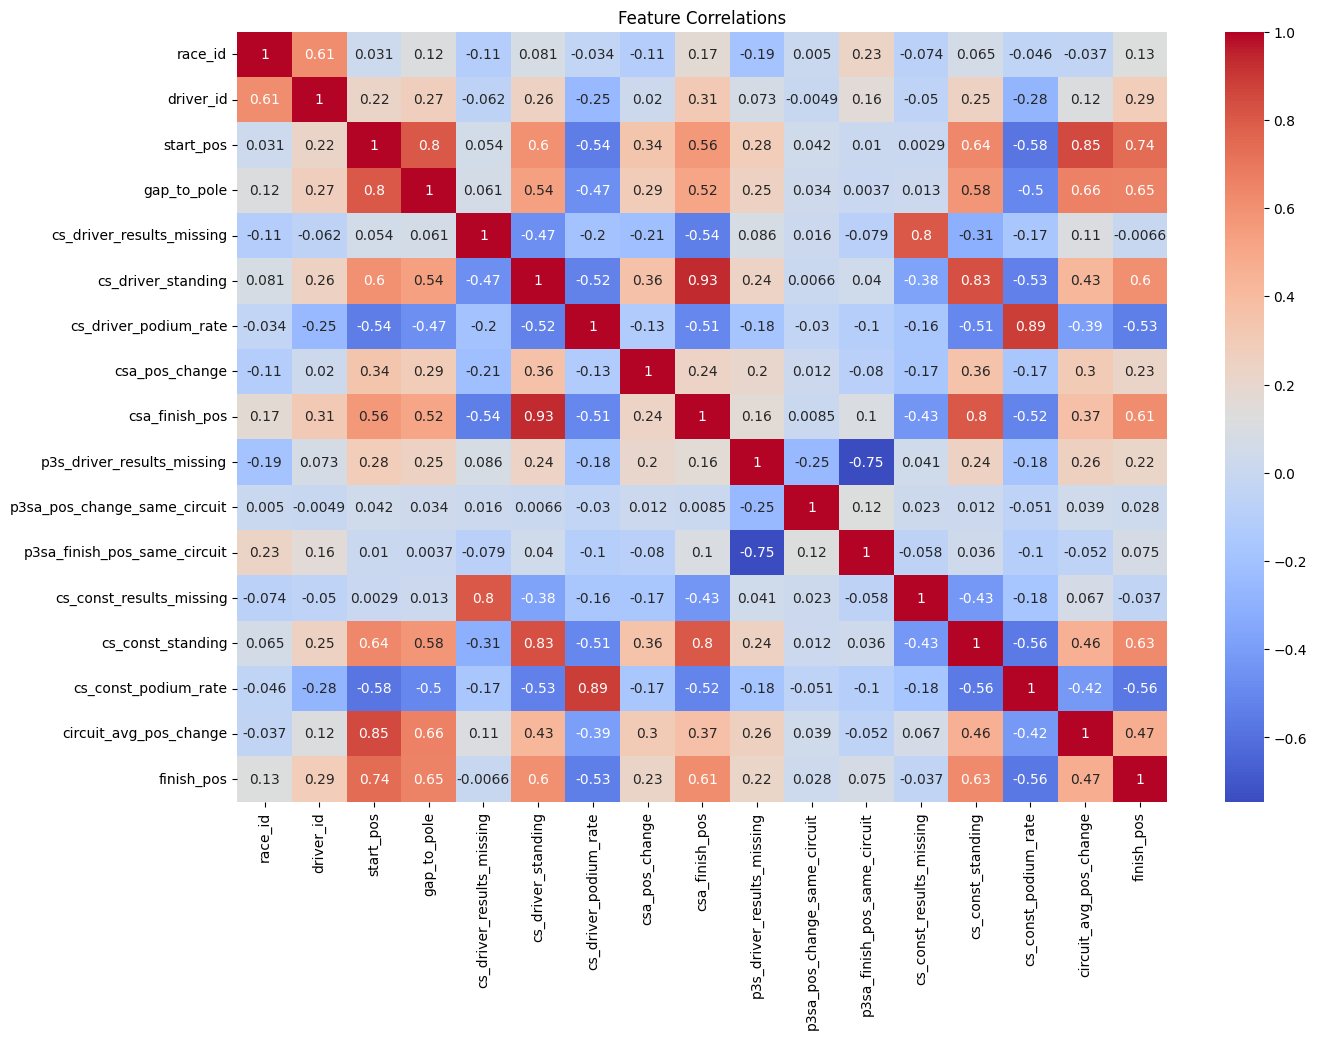

In [4]:
correlationTable = data.corr()
plt.figure(figsize=(15, 10))
plt.title("Feature Correlations")
sns.heatmap(correlationTable, annot=True, cmap='coolwarm')

### 2.3 Feature Importance
Feature importance give us a score for each data feature, the higher the score the more important the feature is.

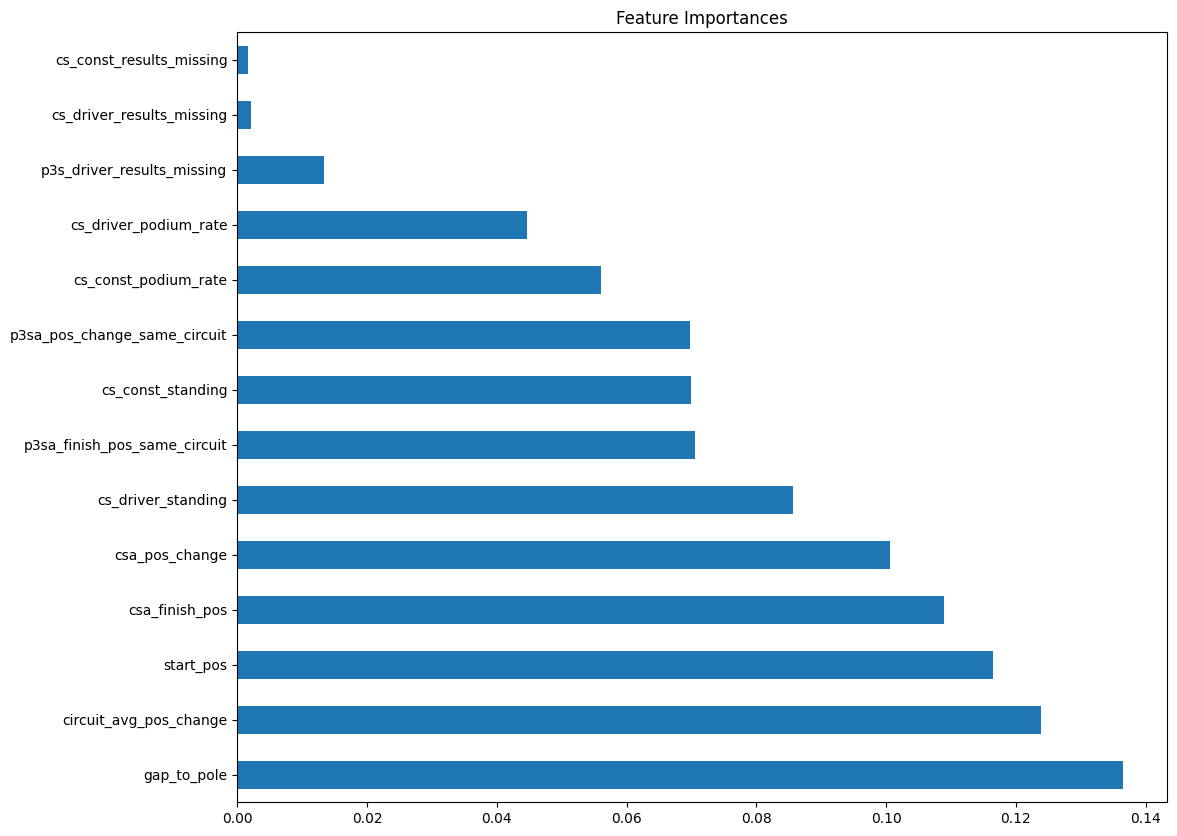

In [5]:
from sklearn.ensemble import ExtraTreesClassifier

TreeModel = ExtraTreesClassifier()
X = data.iloc[:, 2:16]
y = data.iloc[:, -1]
TreeModel.fit(X,y)

model = pd.Series(TreeModel.feature_importances_, index=X.columns)

model.nlargest(15).plot(kind='barh', figsize=(12, 10))
plt.title("Feature Importances")
plt.show()

The `gap_to_pole` and `circuit_avg_pos_change` is the most important feature in predicting the "finish_pos"

### 2.4 finishing the dataset
according to the test we just did the `race_id` and the `driver_id` have no use in our model and doesn't change the result of the race

In [6]:
final_data = data.iloc[:, 2:]

let's get some data about our dataset

In [7]:

info_check = final_data.describe()
info_check = info_check.transpose()
info_check

count       mean       std   min      25%  \
start_pos                     6008.0  10.654461  6.268620   0.0  5.00000   
gap_to_pole                   6008.0   0.343519  0.279347   0.0  0.12075   
cs_driver_results_missing     6008.0   0.103362  0.304457   0.0  0.00000   
cs_driver_standing            6008.0   9.633489  6.993885   0.0  3.00000   
cs_driver_podium_rate         6008.0   0.170699  0.292606   0.0  0.00000   
csa_pos_change                6008.0   1.612109  2.557920 -11.0  0.00000   
csa_finish_pos                6008.0   7.841275  4.947897   0.0  3.90000   
p3s_driver_results_missing    6008.0   0.385652  0.486790   0.0  0.00000   
p3sa_pos_change_same_circuit  6008.0   0.896045  2.822021 -15.0  0.00000   
p3sa_finish_pos_same_circuit  6008.0   4.796247  5.095313   0.0  0.00000   
cs_const_results_missing      6008.0   0.069740  0.254730   0.0  0.00000   
cs_const_standing             6008.0   5.228529  3.360164   0.0  2.00000   
cs_const_podium_rate          6008.0   0.176696  0.272400   0.0  0.00000   
circuit_avg_pos_change        6008.0   1.827605  2.904339 -18.0 -0.53000   
finish_pos                    6008.0   8.826897  5.150441   1.0  4.00000   

                                 50%       75%   max  
start_pos                     10.000  16.00000  26.0  
gap_to_pole                    0.274   0.50225   1.0  
cs_driver_results_missing      0.000   0.00000   1.0  
cs_driver_standing             9.000  15.00000  31.0  
cs_driver_podium_rate          0.000   0.25000   1.0  
csa_pos_change                 1.200   3.00000  17.0  
csa_finish_pos                 8.000  11.36000  23.0  
p3s_driver_results_missing     0.000   1.00000   1.0  
p3sa_pos_change_same_circuit   0.000   2.00000  18.0  
p3sa_finish_pos_same_circuit   3.500   8.50000  24.0  
cs_const_results_missing       0.000   0.00000   1.0  
cs_const_standing              5.000   8.00000  13.0  
cs_const_podium_rate           0.000   0.32000   1.0  
circuit_avg_pos_change         1.440   3.75000  17.0  
finish_pos                     8.000  13.00000  24.0

We can see that we have around 6008 rows with no issues here. but the mean and the STD is vary from variable to another, therefore we have to scale the data to prevent any bias

Let's check the relationship with the `finish_pos` and the features by plotting it

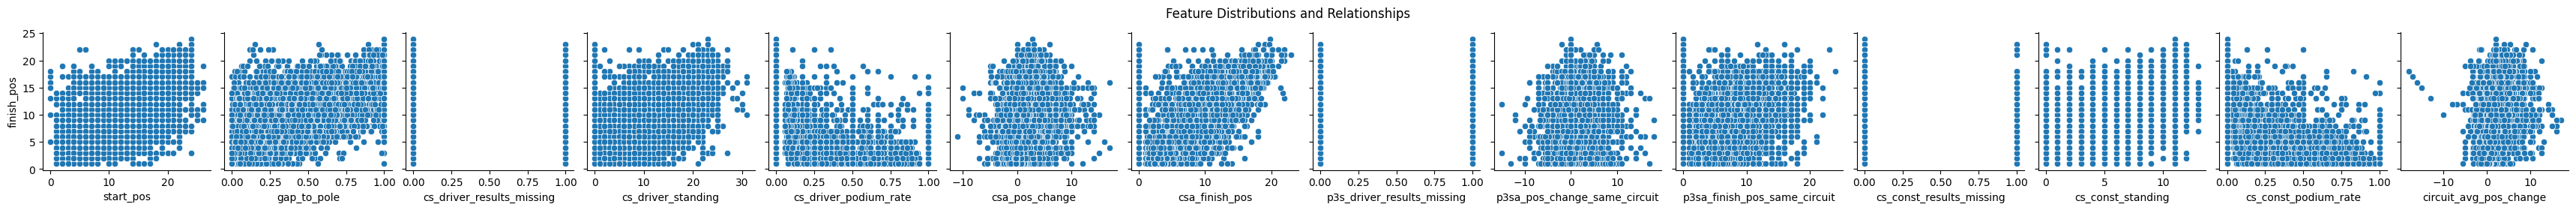

In [8]:
sns.pairplot(data=final_data,
             y_vars=['finish_pos'],
             x_vars=final_data.iloc[:, :-1].columns.values.tolist())
plt.suptitle('Feature Distributions and Relationships', y=1.08)
plt.show()

As you can see in the above plots all the data is distributed evenly across the graph describing a feature value. expect some plots only containing value around 1 and 0 meaning they're booleans values.

## 3.0 Preprocessing the data ##

Before starting to train the model we need to take some steps, which is Preprocessing the data. 

### The Classification Approch

Using classification instead of regression for this model seem more realistic and here's why:
- each predicted feature vary from era to another and circuits changes which in this case regression model will have hard time to accurately predict the finale result of the gird position with only the giving data.
- regression model treat each prediction or driver as separately so it may duplicate the same prediction
- regression model can predict a number that's not possible such as higher than the number of driver

To solve these issues the classification model was used, and here's how it should work
1. Create a pair of each pair of driver that can be created such as driver A and B
2. Subtract the difference btween each driver's performance (and will create a new dataset for that below)
3. The model will generate a boolen value such as 1 if Driver A wins and 0 for Drive A loss or draw

By using this method we don't need to worry about different eras or circuit beacuse the Driver A and B will be in the same race.

Column names for the new dataset:

In [9]:
New_dataset = data.columns.values.tolist()[2:-1] + ['win']

To calculate the differences in each driver performance features between Drivers A and B, and output the boolen values indicating the winner

In [10]:
def driver_differences(input):
   # creating a list to store the differences between drivers
    differences_dataset = []
    # iterating through all drivers in the dataset to find the differences between them
    for driverA in input.itertuples(index=False, name='DriverA'):
        # finding all drivers in the same race as driver A
        in_same_race = input[input['race_id'] == getattr(driverA, 'race_id')]
        # iterating through all drivers in the race
        for driverB in in_same_race.itertuples(index=False, name='DriverB'):
            # if driver A and driver B are the same, skip
            if getattr(driverA, 'driver_id') == getattr(driverB, 'driver_id'):
                continue
            
            # difference in features of drivers A and B
            drivers_difference = np.subtract(driverA, driverB)[2:]

            # difference in finish_pos of drivers A and B
            finishing_difference = drivers_difference[-1]
            # if driver A finished ahead of driver B, driver A wins
            drivers_difference[-1] = int(finishing_difference < 0)
            # appending the differences to the dataset
            differences_dataset.append(drivers_difference)

    differences_dataset = pd.DataFrame(differences_dataset, columns=New_dataset) 
    return differences_dataset

## 3.2 split the dataset

Using the above script, the data we need is generated, which now we will split into 3 sets:
- First test which will have 5 races of a year and then will be evaluted for the grid place accuracy
- Second test which will have data to evaluat the win/lose accuracy of the model
- Lastly a train dataset which will have the rest of the dataset

note for this step i imported more data about reace from [Ergast API](http://ergast.com/mrd/) the data have more data about the races history in the file races.csv

In [11]:
# First test compare the races
racesdata = pd.read_csv('races.csv')
first_test_race_ids = racesdata[(racesdata['year'] == 2020) & (racesdata['round'].isin([2, 5, 15, 18, 20]))]['race_id']
# extract first tes set from the entire dataset and perform driver feature subtraction
first_test = data[data['race_id'].isin(first_test_race_ids)]
first_test = driver_differences(first_test)
# split first test into its input and output features
X_first_test = first_test.iloc[:, :-1]
y_first_test = first_test.iloc[:, -1]

# perform driver feature subtraction on the remaining dataset 
rest_of_data = data[~data['race_id'].isin(first_test_race_ids)]
rest_of_data = driver_differences(rest_of_data)
# split rest of the data into its input and output features
X_rest_of_data = rest_of_data.iloc[:, :-1]
y_rest_of_data = rest_of_data.iloc[:, -1]

# split rest_of_data into the input and output features of second test and training sets
from sklearn.model_selection import train_test_split
X_train, X_second_test, y_train, y_second_test = train_test_split(X_rest_of_data.copy(), 
                                                        y_rest_of_data.copy(), 
                                                        test_size=0.08, random_state=1)

# concatenate first test and second test arrays of input and output features
X_test = pd.concat([X_first_test, X_second_test])
y_test = pd.concat([y_first_test, y_second_test])

# reorder dataframe indices
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [12]:
print('Training set size:', y_train.shape[0])
print('Testing set size:', y_test.shape[0])

Training set size: 85587
Testing set size: 7443


### 3.3 Feature scaling

We need scalling to prevent any kind of bias toward certian features and make the proccess of training the model faster, and for this model we are using standardisation which subtracting the mean from the feature values and dividing the result by the standard deviation:

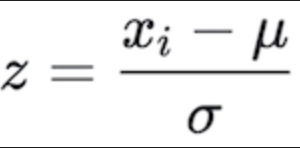

this will create a Gaussian distribution with 0 mean and unit variance. And the boolen feature we saw earlier doesn't need scalling

In [13]:
# standardising input data
from sklearn.preprocessing import StandardScaler

# exclude missing-data columns for feature scaling
scalled_columns = ['start_pos', 'gap_to_pole', 'cs_driver_standing', 'cs_driver_podium_rate', 'csa_pos_change', 
                           'csa_finish_pos', 'p3sa_pos_change_same_circuit', 'p3sa_finish_pos_same_circuit', 
                           'cs_const_standing', 'cs_const_podium_rate', 'circuit_avg_pos_change']
# fit the standardiser to the training set
standardiser = StandardScaler().fit(X_train[scalled_columns])
# scale the training and test set
X_train[scalled_columns] = standardiser.transform(X_train[scalled_columns])
X_test[scalled_columns] = standardiser.transform(X_test[scalled_columns])

## 4.0 Initial prediction model

### 4.1 Train and save the model

The initial model have two hidden layers, each containing 16 neurons. To enhance the optimization process, the ReLU (Rectified Linear Unit) activation function is employed in the hidden layers, while the output layer utilizes the sigmoid function to facilitate binary classification. To mitigate the risk of encountering false local minima, Xavier (Glorot) normal initialization was applied across all layers. Given that this is a classification task, binary cross-entropy was utilized as the loss function, and the Adam optimization algorithm was adopted.

The training process was conducted over 100 epochs, utilizing a batch size of 256.

In [14]:
model = keras.Sequential([
    keras.layers.Dense(16, activation='relu', input_shape=(14,), kernel_initializer='glorot_normal'),
    keras.layers.Dense(16, activation='relu', kernel_initializer='glorot_normal'),
    keras.layers.Dense(1, activation='sigmoid', kernel_initializer='glorot_normal')])

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=100, validation_split = 0.2, batch_size=256, verbose=0)

c:\Users\omaro\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Accuracy vs Epoch graph for the training and validation set:

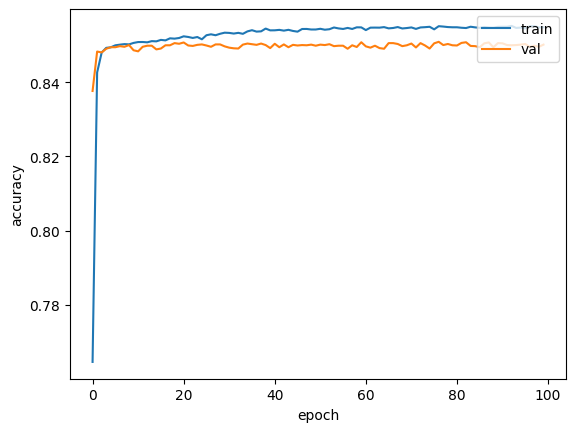

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_' + 'accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

Loss vs Epoch graph for the training and validation set:

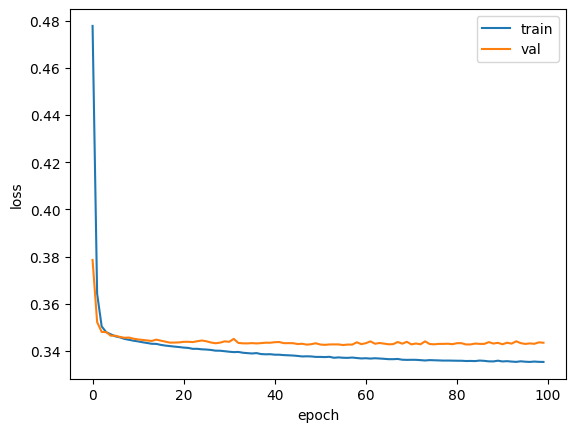

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_' + 'loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

The graph of the loss function indicates that the training set loss consistently declines, whereas the loss for the validation set starts to rise after approximately 60 epochs, forming an elbow-shaped curve. This pattern suggests that the model has overfitted, indicating that it has become overly too trained for that dataset, with random fluctuations or statistical noise in the training dataset, and is less able to generalise to new data. Additionally, there is a possibility that the model converged to a local minimum, not a global minimum.

saving the model so we can use it with Tensorflow Serving

In [17]:
!mkdir -p model
model.save('model/first_model.keras') 

A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file model already exists.
Error occurred while processing: model.


## 4.2 Evaluate the model

We need to evaluate the first model for detecting and omiting any obsolete or skewed features and compare it accuracy to the model comes in the next stage. we're using four metrics to evaluate the model 1-test accuracy 2-output vs feature value curves 3- output distribution curves 4- confusion matrix 

In [18]:
first_model = tf.keras.models.load_model('model/first_model.keras')
first_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,589 (6.21 KB)

 Trainable params: 529 (2.07 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,060 (4.14 KB)

Predict the results of the `X_test` dataset, having 0.5 as the binary classification threshold. The 0.5 threshold is only used for the first model for a rough estimation. The final model identifies an optimal threshold through the analysis of a ROC curve.

In [20]:
predictions = first_model.predict(X_test).flatten()
classifications = np.round(predictions)

233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step


1) By evaluating the model on the test set, it can be seen that its test accuracy is 85%. Considering that this is an initial model with a basic neural network structure, 85% is a rather high accuracy figure, suggesting that the patterns in the data may not be too complicated.

In [21]:
test_loss, test_acc = first_model.evaluate(X_test, y_test, verbose=0)
print('test accuracy:', test_acc)

test accuracy: 0.8501948118209839


2) The confusion matrix to figure out the precision, recall, and F1 score for the initial model. As you can see below, all three metrics sit at 0.85, which means the 0.5 threshold for the model is just right—there's no need to compromise between recall and precision since they match perfectly. Additionally, the counts of false negatives and false positives are pretty close (around 640 each), just like the true positives and true negatives (about 3500). This shows that the model is equally likely to misclassify both classes (0: Driver A loses, 1: Driver A wins), indicating there's no bias towards either class.

In [22]:
from sklearn.metrics import confusion_matrix

c_matrix = confusion_matrix(y_test, classifications)
true_pos = c_matrix[0][0]
false_neg = c_matrix[0][1]
false_pos = c_matrix[1][0]
precision = round(true_pos / (true_pos + false_pos), 2)
recall = round(true_pos / (true_pos + false_neg), 2)
f1_score = round(2 * ((precision * recall) / (precision + recall)), 2)

print('Confusion Matrix:\n', c_matrix)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1_score)

Confusion Matrix:
 [[3102  587]
 [ 528 3226]]
Precision: 0.85
Recall: 0.84
F1 Score: 0.84


3) The output distribution curves below display how the model's results are spread out for class 0 (where Driver A loses) and class 1 (where Driver A wins). You can see that the majority of the outputs for class 0 cluster around 0.0, while those for class 1 gather around 1.0. This indicates that the model is quite precise in its output distribution.

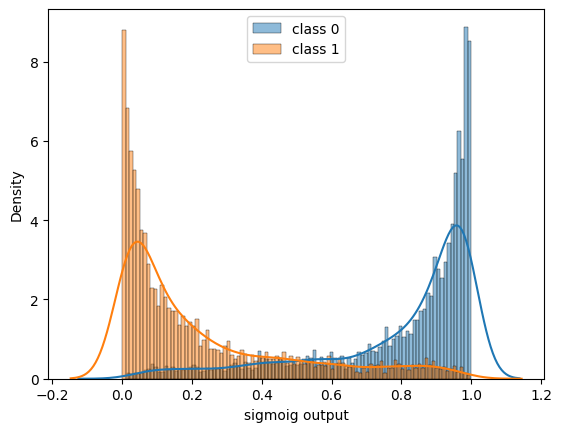

In [30]:
win = []
lose = []

for i in range(len(predictions)):
    if y_test[i] == 0:
        win.append(predictions[i])
    else:
        lose.append(predictions[i])

sns.histplot(lose, bins=100, label="class 0", kde=True, stat="density", kde_kws=dict(cut=3))
sns.histplot(win, bins=100, label="class 1", kde=True , stat="density", kde_kws=dict(cut=3))
plt.xlabel("sigmoig output")
plt.legend()
plt.show()

4) The curves below, created using kernel density estimate plots, show how the loss (class 0) and win (class 1) outputs are distributed based on the values of each feature. For example, the output vs `start_pos` curve (the first graph) indicates that when `start_pos` has a negative difference (which reflects the difference in feature values between Drivers A and B), Driver A tends to win. On the flip side, a positive difference in `start_pos` suggests that Driver A is likely to lose. This makes sense because a negative difference means Driver A starts ahead of Driver B, increasing the chances of finishing first.

C:\Users\omaro\AppData\Local\Temp\ipykernel_11052\1064242337.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right')
C:\Users\omaro\AppData\Local\Temp\ipykernel_11052\1064242337.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right')
C:\Users\omaro\AppData\Local\Temp\ipykernel_11052\1064242337.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right')
C:\Users\omaro\AppData\Local\Temp\ipykernel_11052\1064242337.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ig

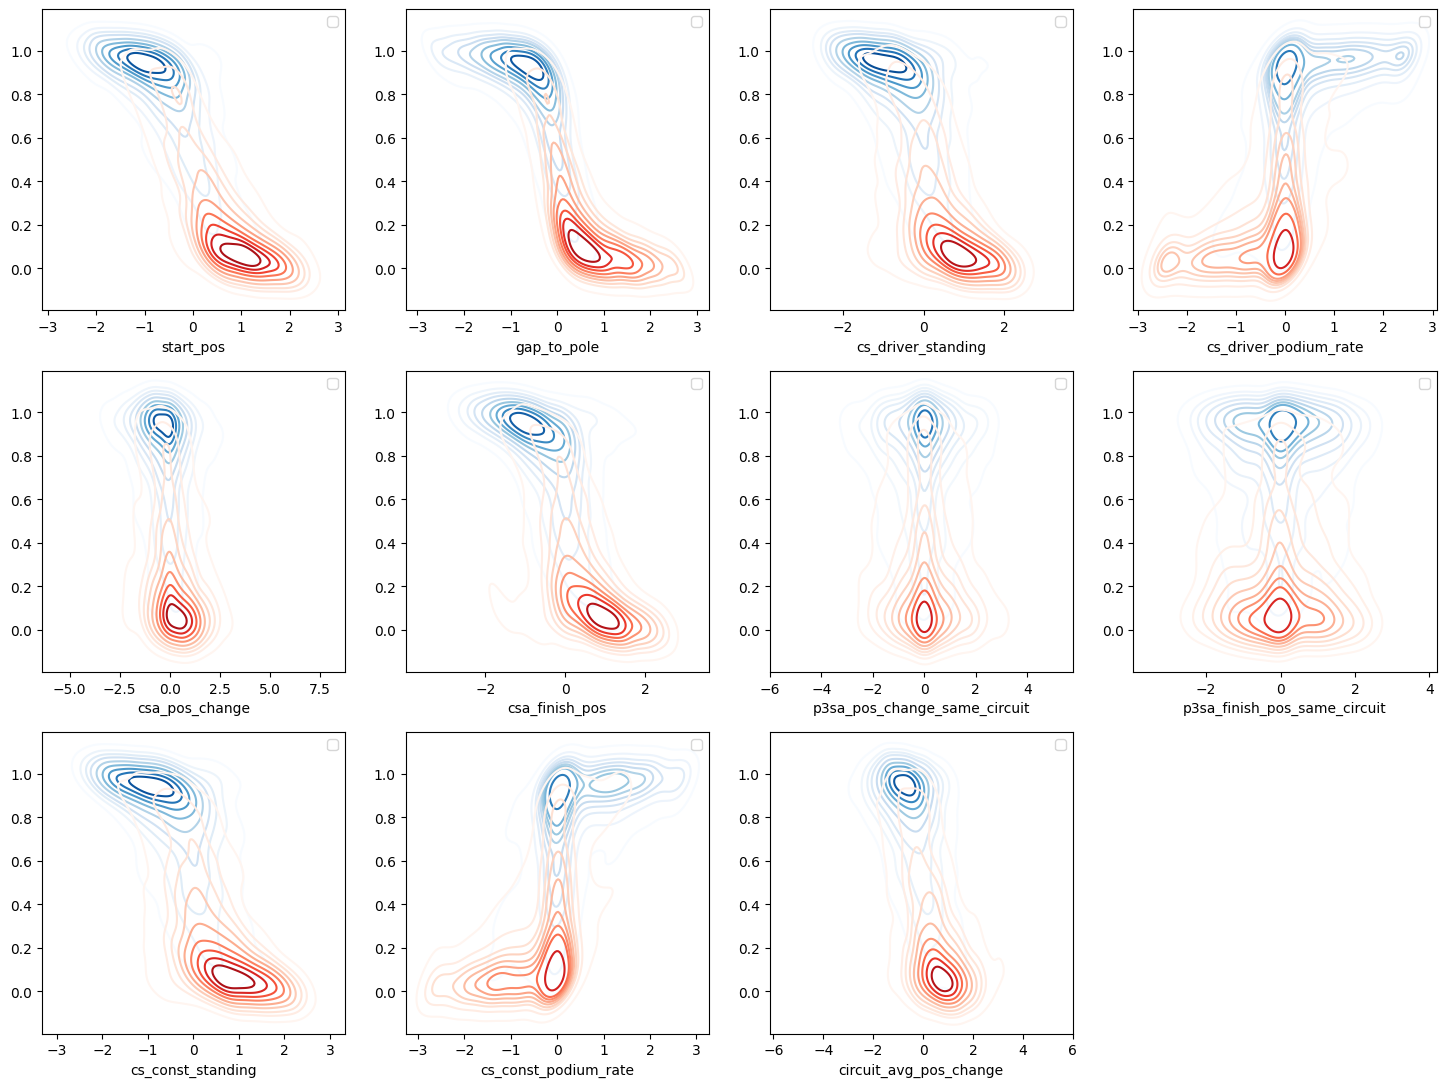

In [37]:
fig = plt.figure(figsize=(18, 18))
for x, feature in enumerate(scalled_columns):
    win = []
    lose = []
    featwin = []
    featlose = []
    for i in range(len(predictions)):
        if y_test[i] == 0:
            lose.append(predictions[i])
            featlose.append(float(X_test.loc[i, [feature]]))
        else:
            win.append(predictions[i])
            featwin.append(float(X_test.loc[i, [feature]]))
    ax = fig.add_subplot(4, 4, x+1)
    ax.set_xlabel(feature)
    sns.kdeplot(x=featwin, y=win, label="win",
                 cmap="Blues", ax=ax)
    sns.kdeplot(x=featlose, y=lose, label="lose",
                 cmap="Reds", ax=ax)
    plt.legend(loc='upper right')
plt.show()

Just like the `start_pos` curve, most of the distribution curves above aligned well with what we expected theoretically. However, there were a couple of exceptions: `p3sa_pos_change_same_circuit` and `p3sa_finish_pos_same_circuit`. In these two curves, the feature values don’t seem to affect the model's output at all, since we see similar win and loss predictions across different feature values. This indicates that these features are unnecessary. So, we decided to remove them from the dataset columns, as

In [38]:
colums = ['start_pos', 'gap_to_pole', 'cs_driver_results_missing', 'cs_driver_standing', 'cs_driver_podium_rate', 'csa_pos_change',
       'csa_finish_pos', 'cs_const_results_missing', 'cs_const_standing', 'cs_const_podium_rate', 'circuit_avg_pos_change']
X_train = X_train.loc[:, colums]
X_test = X_test.loc[:, colums]

## 5.0 Random search for tuning hyperparameters

To enhance the model's performance, it's essential to adjust its hyperparameters. For this research project, we opted for random search over grid search to achieve better hyperparameter tuning. Additionally, we implemented 5-fold cross-validation to address the limited data points and avoid overfitting. We utilized TensorFlow's HParams Dashboard to identify the best parameters following the random search.

In [ ]:
# import TensorBoard HParams plugin
from tensorboard.plugins.hparams import api as hp

# define the model
%load_ext tensorboard
# Clear any logs from previous runs
!del -rf ./logs/ 

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Invalid switch - "logs".


For this random search, nine hyperparameters were tested:
- number of hidden layers (2, 3, 4)
- number of neurons in each hidden layer (4, 8, 16, 32, 64, 128, 256, 512)
- optimiser algorithm (adam, rmsprop, sgd)
- learning rate (0.01, 0.1, 0.3,  0.5)
- momentum (0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9)
- dropout rate (0.5, 0.6, 0.7, 0.8)
- weight constraint (1, 2, 3, 4, 5)
- weight initialiser (normal, he_normal, he_uniform, glorot_normal, glorot_uniform)
- batch size (32, 64, 128, 256, 512, 1024, 2048)

Once the values to be tested were identified, the experiment setup was logged out by TensorBoard:

In [ ]:
HP_HIDDEN_LAYERS = hp.HParam('hidden_layers', hp.IntInterval(2, 4))
HP_HL1_NEURONS = hp.HParam('HL1_neurons', hp.Discrete([4, 8, 16, 32, 64, 128, 256, 512]))
HP_HL2_NEURONS = hp.HParam('HL2_neurons', hp.Discrete([4, 8, 16, 32, 64, 128, 256, 512]))
HP_HL3_NEURONS = hp.HParam('HL3_neurons', hp.Discrete([4, 8, 16, 32, 64, 128, 256, 512]))
HP_HL4_NEURONS = hp.HParam('HL4_neurons', hp.Discrete([4, 8, 16, 32, 64, 128, 256, 512]))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'rmsprop', 'sgd']))
HP_LEARNING_RATE = hp.HParam('learning_rate', hp.Discrete([0.01, 0.1, 0.3,  0.5]))
HP_MOMENTUM = hp.HParam('momentum', hp.Discrete([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]))
HP_DROPOUT_RATE = hp.HParam('dropout_rate', hp.Discrete([0.5, 0.6, 0.7, 0.8]))
HP_WEIGHT_CONSTRAINT = hp.HParam('weight_constraint', hp.IntInterval(1, 5))
HP_WEIGHT_INIT = hp.HParam('weight_init', hp.Discrete(['normal', 'he_normal', 'he_uniform','glorot_normal', 'glorot_uniform']))
HP_BATCH_SIZE = hp.HParam('batch_size', hp.Discrete([32, 64, 128, 256, 512, 1024, 2048]))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(
        hparams=[HP_HIDDEN_LAYERS, HP_HL1_NEURONS, HP_HL2_NEURONS, HP_HL3_NEURONS, HP_HL4_NEURONS,
                 HP_OPTIMIZER, HP_LEARNING_RATE, HP_MOMENTUM, HP_DROPOUT_RATE, 
                 HP_WEIGHT_CONSTRAINT, HP_WEIGHT_INIT, HP_BATCH_SIZE],
        metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
    )

The `model_validetor` function is responsible for tuning the hyperparameters. The training process is quite similar to what we used for the first model, but this time, the hyperparameters are not hardcoded. Instead, they come from an HParams dictionary and are utilized throughout the training function. After building the model, we implement 5-fold cross-validation, which divides the training set into 5 parts. The model is trained on 4 of those parts and tested on the remaining one. Once training is complete, we average the performance from all 5 folds to get the final validation accuracy for the model.

We set a maximum of 500 epochs for training, but it will stop early if the validation accuracy doesn't improve for 20 epochs to avoid overfitting.

In [ ]:
from sklearn.model_selection import KFold

# define the 5-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
X_kfold = X_train.to_numpy()
y_kfold = y_train.to_numpy()

# create a funcation to log the hparams and metrics
def model_validator(hparams):
    hidden_neurons = [hparams[HP_HL1_NEURONS], hparams[HP_HL2_NEURONS], hparams[HP_HL3_NEURONS], hparams[HP_HL4_NEURONS]]
    
    model = keras.Sequential()
    model.add(keras.layers.Dense(hidden_neurons[0], activation='relu', 
                                 input_shape=(11,), kernel_initializer=hparams[HP_WEIGHT_INIT], 
                                 kernel_constraint=max_norm(hparams[HP_WEIGHT_CONSTRAINT])))
    model.add(keras.layers.Dropout(hparams[HP_DROPOUT_RATE]))
    # add hidden layers
    for L in range(1, hparams[HP_HIDDEN_LAYERS]):
        model.add(keras.layers.Dense(hidden_neurons[L], activation='relu', 
                                     kernel_initializer=hparams[HP_WEIGHT_INIT], 
                                     kernel_constraint=max_norm(hparams[HP_WEIGHT_CONSTRAINT])))
        model.add(keras.layers.Dropout(hparams[HP_DROPOUT_RATE]))
    # add output layer
    model.add(keras.layers.Dense(1, activation='sigmoid', kernel_initializer=hparams[HP_WEIGHT_INIT]))
    # compile the model
    optimizer = hparams[HP_OPTIMIZER]
    if optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=hparams[HP_LEARNING_RATE])
    elif optimizer == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=hparams[HP_LEARNING_RATE], momentum=hparams[HP_MOMENTUM])
    elif optimizer == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=hparams[HP_LEARNING_RATE], momentum=hparams[HP_MOMENTUM])
    
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    # fit the model
    kfold_accuracies = []
    for train_index, test_index in kfold.split(X_kfold):
        X_train, X_test, y_train, y_test = X_kfold[train_index], X_kfold[test_index], y_kfold[train_index], y_kfold[test_index]
        early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
        model.fit(X_train, y_train, epochs=500, validation_split = 0.2, batch_size=hparams[HP_BATCH_SIZE], verbose=2, callbacks=[early_stop])
        _, accuracy = model.evaluate(X_test, y_test)
        kfold_accuracies.append(accuracy)
    # return the mean accuracy
    return np.mean(kfold_accuracies)

After each run, make sure to record a summary of the hyperparameters along with the final accuracy.

In [ ]:
def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        accuracy = model_validator(hparams)
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

This for-loop below goes through 80 iterations of hyperparameter tuning, which means it tests out 80 different models using random search, using the `domain.sample_uniform` method for each parameter. After each round, the test accuracy gets logged into TensorBoard.

In [46]:
num_iterations = 80

for iteration in range(num_iterations):
    hparams = {
        HP_HIDDEN_LAYERS : HP_HIDDEN_LAYERS.domain.sample_uniform(),
        HP_HL1_NEURONS : HP_HL1_NEURONS.domain.sample_uniform(),
        HP_HL2_NEURONS : HP_HL2_NEURONS.domain.sample_uniform(),
        HP_HL3_NEURONS : HP_HL3_NEURONS.domain.sample_uniform(),
        HP_HL4_NEURONS : HP_HL4_NEURONS.domain.sample_uniform(),
        HP_OPTIMIZER : HP_OPTIMIZER.domain.sample_uniform(),
        HP_LEARNING_RATE : HP_LEARNING_RATE.domain.sample_uniform(),
        HP_MOMENTUM : HP_MOMENTUM.domain.sample_uniform(),
        HP_DROPOUT_RATE : HP_DROPOUT_RATE.domain.sample_uniform(),
        HP_WEIGHT_CONSTRAINT : HP_WEIGHT_CONSTRAINT.domain.sample_uniform(),
        HP_WEIGHT_INIT : HP_WEIGHT_INIT.domain.sample_uniform(),
        HP_BATCH_SIZE : HP_BATCH_SIZE.domain.sample_uniform()}

    run_name = "run-%d" % (iteration+1)
    print('--- Starting trial: %s' % run_name)
    print({h.name: hparams[h] for h in hparams})
    run('logs/hparam_tuning/' + run_name, hparams)

--- Starting trial: run-1
{'hidden_layers': 4, 'HL1_neurons': 32, 'HL2_neurons': 128, 'HL3_neurons': 32, 'HL4_neurons': 8, 'optimizer': 'adam', 'learning_rate': 0.5, 'momentum': 0.7, 'dropout_rate': 0.7, 'weight_constraint': 1, 'weight_init': 'he_uniform', 'batch_size': 32}
Epoch 1/500


c:\Users\omaro\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1712/1712 - 3s - 2ms/step - accuracy: 0.5058 - loss: 0.7084 - val_accuracy: 0.5003 - val_loss: 0.6942
Epoch 2/500
1712/1712 - 2s - 1ms/step - accuracy: 0.4985 - loss: 0.7015 - val_accuracy: 0.5003 - val_loss: 0.7076
Epoch 3/500
1712/1712 - 2s - 991us/step - accuracy: 0.4997 - loss: 0.7031 - val_accuracy: 0.5003 - val_loss: 0.6962
Epoch 4/500
1712/1712 - 2s - 1ms/step - accuracy: 0.4999 - loss: 0.7031 - val_accuracy: 0.4997 - val_loss: 0.6951
Epoch 5/500
1712/1712 - 2s - 994us/step - accuracy: 0.5003 - loss: 0.7015 - val_accuracy: 0.5003 - val_loss: 0.6956
Epoch 6/500
1712/1712 - 2s - 994us/step - accuracy: 0.4997 - loss: 0.7024 - val_accuracy: 0.5003 - val_loss: 0.6934
Epoch 7/500
1712/1712 - 2s - 988us/step - accuracy: 0.4983 - loss: 0.7015 - val_accuracy: 0.4997 - val_loss: 0.7447
Epoch 8/500
1712/1712 - 2s - 997us/step - accuracy: 0.5011 - loss: 0.7011 - val_accuracy: 0.4997 - val_loss: 0.6937
Epoch 9/500
1712/1712 - 2s - 985us/step - accuracy: 0.4974 - loss: 0.7015 - val_accuracy: 

Using the HParams dashboard in TensorBoard to see the results of your hyperparameter tuning. Instead of showing the full table, I've included a screenshot of a small part of it below, since TensorBoard clears its data soon after the tuning process.

In [49]:
%tensorboard --logdir logs/hparam_tuning

Reusing TensorBoard on port 6006 (pid 8268), started 0:25:12 ago. (Use '!kill 8268' to kill it.)

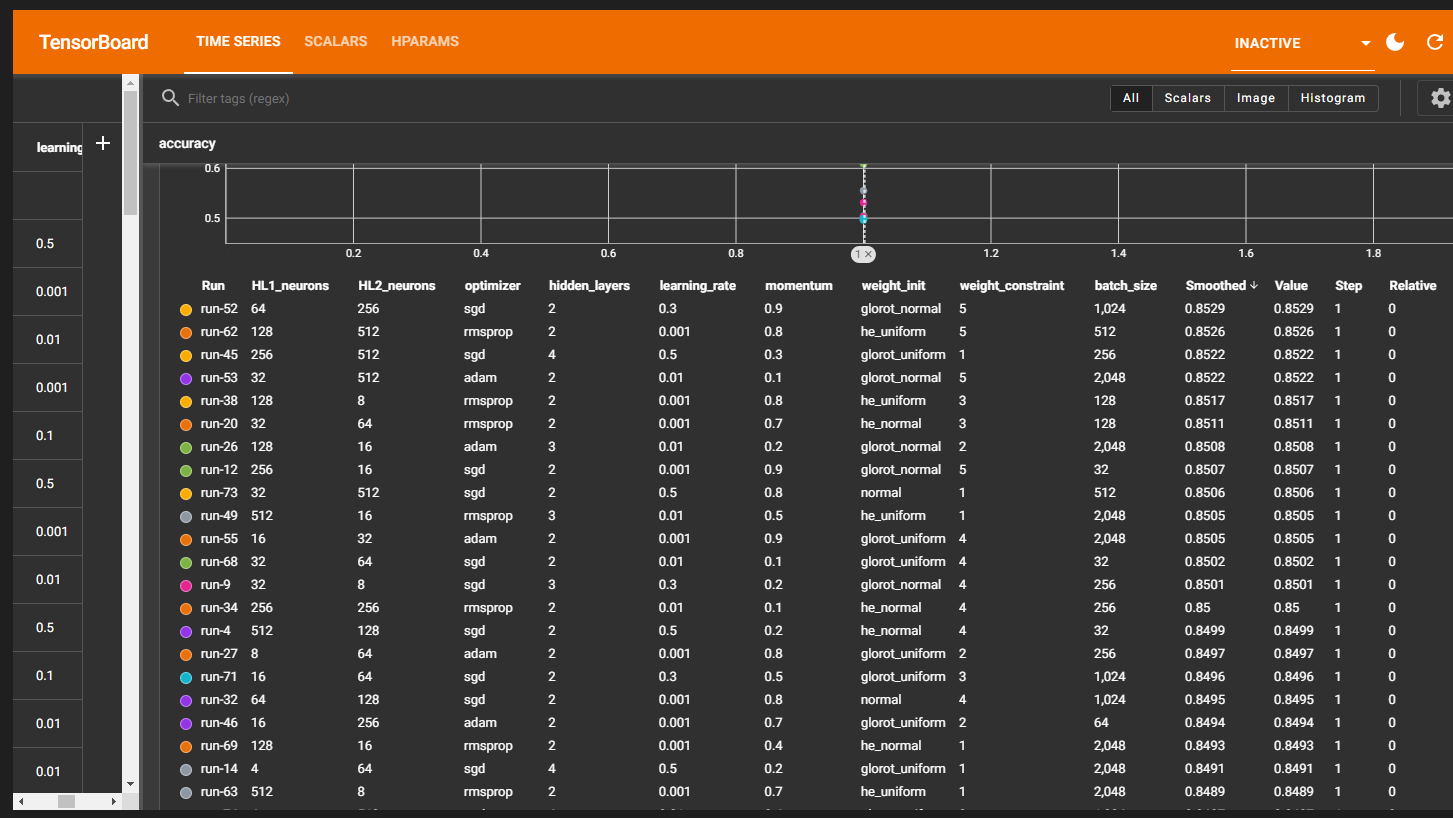

From the HParams random search, the optimal hyperparameters were found as below:

- hidden layers (HL): 2
- HL1 neurons: 64
- HL2 neurons: 256
- optimizer: sgd
- learning rate: 0.3
- momentum: 0.9
- dropout rate: 0.7
- weight constraint: 5
- weight init: glorot_normal
- batch size: 1024

ACCURACY: 0.8529